<a href="https://colab.research.google.com/github/Adegbite-Joshua/Learning-Python/blob/master/pytorch/DCGAN_Implemetation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
"""
Training of GAN network on MNIST dataset with Discriminator and Generator imported from models.py
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from models import Discriminator, Generator, initialize_weights



In [6]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        )
    ]
)

In [7]:
dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)


opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

Epoch [0/5] Batch 0/938 \ Loss D: -0.5136, loss G: -0.2275


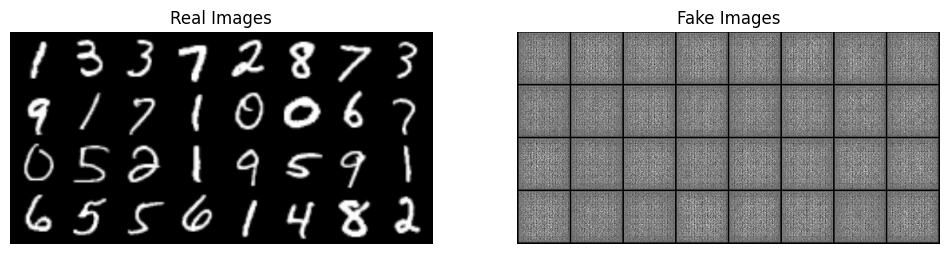

In [ ]:
import matplotlib.pyplot as plt


for epoch in range(NUM_EPOCHS):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)

    for _ in range(CRITIC_ITERATIONS):
      noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

      for p in critic.parameters():
        p.data.clamp(-WEIGHT_CLIP, WEIGHT_CLIP)

    # Train Generator
    output = critic(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    # Print losses occasionally and print to tensorboard
    if batch_idx % 100 == 0:
      print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \ Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")

      with torch.no_grad():
        fake = gen(fixed_noise)
        # Take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(
            real[:32], normalize=True
        )
        img_grid_fake = torchvision.utils.make_grid(
            fake[:32], normalize=True
        )

        # Convert grid of images to numpy for display
        np_img_real = img_grid_real.cpu().numpy().transpose(1, 2, 0)
        np_img_fake = img_grid_fake.cpu().numpy().transpose(1, 2, 0)

        # Display images
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(np_img_real)
        ax[0].set_title("Real Images")
        ax[0].axis("off")

        ax[1].imshow(np_img_fake)
        ax[1].set_title("Fake Images")
        ax[1].axis("off")

        plt.show()
      step += 1